<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-и-обработка-данных" data-toc-modified-id="Анализ-и-обработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ и обработка данных</a></span></li><li><span><a href="#Очистка-и-обработка-текста" data-toc-modified-id="Очистка-и-обработка-текста-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Очистка и обработка текста</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Векторизация" data-toc-modified-id="Векторизация-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Векторизация</a></span><ul class="toc-item"><li><span><a href="#Bag-of-words" data-toc-modified-id="Bag-of-words-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Bag of words</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li></ul></li><li><span><a href="#Модели" data-toc-modified-id="Модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модели</a></span><ul class="toc-item"><li><span><a href="#LogisticRegressionCV" data-toc-modified-id="LogisticRegressionCV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegressionCV</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Catboost</a></span><ul class="toc-item"><li><span><a href="#Сatboost-textfeatures" data-toc-modified-id="Сatboost-textfeatures-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Сatboost textfeatures</a></span></li></ul></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li></ul></li><li><span><a href="#Отчёт" data-toc-modified-id="Отчёт-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Отчёт</a></span></li></ul></div>

# Прогнозирование уровня сложности фильмов на английском

**Описание**: Просмотр фильмов на изучаемом языке помогает прокачать знания. Важно выбрать фильм, который подходит по уровню сложности - студент должен понимать 50-70% диалогов.

Есть датасет от заказчика с выборкой фильмов и уровнем сложности. Уровень проставлял заказчик, эксперты просматривали фильмы и делали вывод об их сложности.

**Цель**: разработать ML модель для определения уровня сложности англоязычных фильмов.

**Исходные данные**
- разметка: оценка сложности фильмов (около 200)
- субтитры фильмов
- словарь со словами по уровню языка

**План работы**
- субтитры содержат много мусора, предобработать их, отфильтровать
- рассмотреть добавление дополнительных признаков
- провести токенизацию, лемматизацию
- провести векторизацию признаков различными методами
- обучить различные модели, выбрать лучшую, проверить на тестовой выборке
- использовать метрику `accuracy`, `balanced accuracy`
- построить матрицу ошибок `confusion matrix`, проанализировать предсказания модели по каждому классу

## Подготовка данных

In [1]:
# установка дополнительных библиотек закомментирована
# при ошибках импорта установить нужные

# ! pip install openpyxl
# ! pip install pysrt
# ! pip install nltk

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

# работа с файлами
from chardet.universaldetector import UniversalDetector
from difflib import get_close_matches
from pathlib import Path
import pysrt

# обработка текста
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# векторизация
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ML
from catboost import CatBoostClassifier, cv, metrics, Pool
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split

In [3]:
# постоянные параметры
RND_STATE = 3210

### Загрузка данных

Загружаю файл с разметкой фильмов по уровню сложности

In [4]:
movies = pd.read_excel('English_scores/movies_labels.xlsx', index_col=0)

In [5]:
movies.shape

(241, 2)

In [6]:
movies.head()

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


Датафрейм содержит два столбца - название фильма и уровень английского, рекомендуемый для просмотра. Переименовываю столбцы для удобства

In [8]:
movies.columns = ['movie', 'level']

In [9]:
movies.head()

,movie,level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   241 non-null    object
 1   level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


241 запись, пропусков в данных нет.

### Анализ и обработка данных

Проверяю данные на дубликаты

In [13]:
movies.duplicated().sum()

2

In [12]:
movies[movies['movie'].duplicated()]

,movie,level
id,,
44,Inside_out(2015),B1
68,Powder(1995),B1
84,The_blind_side(2009),B1
99,The_terminal(2004),"A2/A2+, B1"
236,Matilda(1996),C1


В данных 2 полных дубликата и помимо них ещё 3, в которых дублируются названия фильмов, а уровень им присвоен разный. Полные дубликаты удаляю сразу, дубликаты по имени вывожу на просмотр

In [14]:
movies = movies.drop_duplicates().reset_index(drop=True)

In [15]:
movies[movies['movie'].duplicated()]

,movie,level
82,The_blind_side(2009),B1
97,The_terminal(2004),"A2/A2+, B1"
234,Matilda(1996),C1


In [16]:
movies[movies['movie'] == 'The_blind_side(2009)']

,movie,level
73,The_blind_side(2009),B2
82,The_blind_side(2009),B1


In [17]:
movies[movies['movie'] == 'The_terminal(2004)']

,movie,level
81,The_terminal(2004),B1
97,The_terminal(2004),"A2/A2+, B1"


In [18]:
movies[movies['movie'] == 'Matilda(1996)']

,movie,level
55,Matilda(1996),B1
234,Matilda(1996),C1


Оставляю более сложный уровень

In [19]:
movies = movies.drop(movies[(movies['movie'] == 'The_blind_side(2009)') & (movies['level'] == 'B1')].index)
movies = movies.drop(movies[(movies['movie'] == 'The_terminal(2004)') & (movies['level'] == 'A2/A2+, B1')].index)
movies = movies.drop(movies[(movies['movie'] == 'Matilda(1996)') & (movies['level'] == 'B1')].index)
movies = movies.reset_index(drop=True)

In [21]:
movies[movies['movie'].duplicated()]['movie'].count()

0

Посмотрим на баланс классов

In [22]:
movies['level'].value_counts()

B2            101
B1             51
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      4
Name: level, dtype: int64

Представлены категории A2, B1, B2 и C1. Есть смешанные категории. Т.к. данных небольшое количество, лучше сократить количество категорий. Решаю A2/A2+ принять за A2, A2/A2+, B1 - за B1, B1, B2 - за B2 - по принципу присвоения более сложной, наличие возможной A2+ не буду считать за отдельную категорию.

In [23]:
movies['level'] = movies['level'].where(movies['level'] != 'A2/A2+', 'A2')
movies['level'] = movies['level'].where(movies['level'] != 'A2/A2+, B1', 'B1')
movies['level'] = movies['level'].where(movies['level'] != 'B1, B2', 'B2')

In [24]:
movies['level'].value_counts()

B2    109
B1     55
C1     40
A2     32
Name: level, dtype: int64

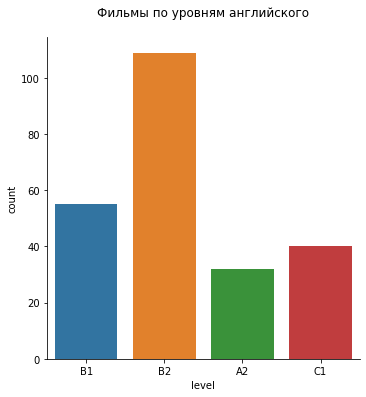

In [25]:
sns.catplot(data=movies, x='level', kind='count').set(title='Фильмы по уровням английского'+ '\n')
plt.show()

Наблюдается дисбаланс классов. Больше всего данных по фильмам с уровнем `B2`, меньше всего - с `A1`

### Очистка и обработка текста

In [26]:
path_sub = Path.cwd() / 'Subtitles_all' / 'Subtitles' / '10_Cloverfield_lane(2016).srt'
sub_all = path_sub.read_text()
sub_all

'1\n00:00:55,279 --> 00:01:07,279\n<font color="#ffff80"><b>Fixed & Synced by bozxphd. Enjoy The Flick</b></font>\n\n2\n00:01:11,280 --> 00:01:12,838\n(CLANGING)\n\n3\n00:01:16,480 --> 00:01:17,833\n(DRAWER CLOSES)\n\n4\n00:01:55,800 --> 00:01:57,597\n(INAUDIBLE)\n\n5\n00:04:07,800 --> 00:04:09,313\n(CELL PHONE RINGING)\n\n6\n00:04:20,200 --> 00:04:22,919\nBEN ON PHONE: <i>Michelle,<br/>please don\'t hang up.</i>\n\n7\n00:04:23,680 --> 00:04:27,673\n<i>Just talk to me, okay?<br/>I can\'t believe you just left.</i>\n\n8\n00:04:28,840 --> 00:04:30,068\n<i>Michelle.</i>\n\n9\n00:04:30,920 --> 00:04:32,273\n<i>Come back.</i>\n\n10\n00:04:34,200 --> 00:04:35,872\n<i>Please say something.</i>\n\n11\n00:04:37,360 --> 00:04:39,555\n<i>Michelle, talk to me.</i>\n\n12\n00:04:40,800 --> 00:04:42,950\n<i>Look, we had an argument.<br/>Couples fight.</i>\n\n13\n00:04:43,040 --> 00:04:45,713\n<i>That is no reason<br/>to just leave everything behind.</i>\n\n14\n00:04:48,040 --> 00:04:50,349\n<i>Runnin

В субтитрах много лишней информации - служебные символы, описание действий в скобках. Время можно использовать для оценки длительности субтитров, но для работы с текстом оно не нужно.

Создаю функцию для очистки субтитров 

In [27]:
# код для предобработки субтитров
HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(DOTS, r'.', txt)  #многоточие меняем на точку
    txt = re.sub(r',', ' ', txt) # запятые меняю на пробел
    txt = ".".join(txt.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
    txt = re.sub(r'\.', ' ', txt) # точку меняю на пробел
    txt = re.sub(r'\?', ' ', txt) # вопрос меняю на пробел
    txt = re.sub(r'\!', ' ', txt) # восклицательный меняю на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
    return txt

In [32]:
clean_subs(sub_all)

" enjoy the flick ben on phone michelle please don't hang up just talk to me okay i can't believe you just left michelle come back please say something michelle talk to me look we had an argument couples fight that is no reason to just leave everything behind running away isn't gonna help it any michelle please newscaster more details on that elsewhere today power has still not been restored to many cities on the southern seaboard in the wake of this afternoon's widespread blackout while there had been some inclement weather in the region the problem seems linked to what authorities are calling a catastrophic power surge that has crippled traffic in the area no no damn okay okay please please please don't hurt me please just let me go okay i won't tell anybody i promise okay please just let me go please man you need fluids you were in shock what are you going to do to me i'm going to keep you alive work on getting handy with these my boyfriend was expecting me he'll send the cops looki

Создаю функцию для предобработки очищенного текста субтитров по алгоритму:

- Токенизация, то есть разбить текст на список из слов.

- Убрать слова, не влияющие на содержание текста, например предлоги, артикли. Для этого использую список стоп-слов из библиотеки `nltk`, дополняю его сокращениями вспомогательных слов.

- Лемматизация - приведение слов к начальной форме с помощью `WordNetLemmatizer` из библиотеки `nltk`.

- Разделяю текст на 3 части, чтобы увеличить количество наблюдений.

In [48]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(["'m", "n't", "'re", "'ve", "'s", "'ll", "'d"])
lemmatizer = WordNetLemmatizer()

def sub_preprocessing(sub_text):
    
    # очистка субтитров
    sub_text = clean_subs(sub_text)
  
    # токенизация
    sub_words_list = nltk.word_tokenize(sub_text)
  
    # удаление стоп-слов - предлогов, артиклей и т.п.
    sub_words_list = [w for w in sub_words_list if not w in stop_words] 
    
    # лемматизация
    sub_words_list = [lemmatizer.lemmatize(w) for w in sub_words_list]
    
    num_words = len(sub_words_list)
  
    # разделение субтитра на 3 части
    sub_text_cleaned = []
    n = num_words // 3
    k = 2 * n
    sub_text_cleaned.append(' '.join(sub_words_list[:n]))
    sub_text_cleaned.append(' '.join(sub_words_list[n:k]))
    sub_text_cleaned.append(' '.join(sub_words_list[k:]))
  
    return sub_text_cleaned

Проверяю работу функции

In [45]:
sub_preprocessing(sub_all)

(["enjoy flick ben phone michelle please hang talk okay ca believe left michelle come back please say something michelle talk look argument couple fight reason leave everything behind running away gon na help michelle please newscaster detail elsewhere today power still restored many city southern seaboard wake afternoon widespread blackout inclement weather region problem seems linked authority calling catastrophic power surge crippled traffic area damn okay okay please please please hurt please let go okay wo tell anybody promise okay please let go please man need fluid shock going going keep alive work getting handy boyfriend expecting send cop looking sorry one looking got fight respect even think trying lucky generosity extends far egg toradol help pain please please let go please nowhere go michelle looked wallet given saved life think acceptable lucky mean found saved life bringing understand attack attack big one sure yet chemical nuclear safe exactly underneath farmhouse forty

Создаю функцию для вычисления общей и средней длительности субтитров в качестве дополнительных признаков.

In [47]:
# функция для определения длительности субтитров
def subtitle_duration(subtitle_path, subtitle_encoding):
    # Открытие файла субтитров с учётом разной кодировки
    try:
        subs = pysrt.open(subtitle_path, encoding=subtitle_encoding)
    except:
        try:
            subs = pysrt.open(subtitle_path, encoding='utf-16')
        except:
            subs = pysrt.open(subtitle_path, encoding='windows-1251')

    duration_avg = 0
    duration_list = []

    for i in range(len(subs)):
        start_time = subs[i].start.to_time()
        end_time = subs[i].end.to_time()
        start_datetime = datetime.combine(datetime.today(), start_time)
        end_datetime = datetime.combine(datetime.today(), end_time)
        
        # Вычисление продолжительности субтитра
        duration = (end_datetime - start_datetime).total_seconds()

        # Сохранение продолжительности в список
        duration_list.append(duration)
        
    duration_avg = sum(duration_list) / len(duration_list)
    return round(sum(duration_list), 2), round(duration_avg, 2)


Заношу обработанный текст субтитров и дополнительные признаки в отдельный датафрейм

In [53]:
df_sub = pd.DataFrame(columns=['sub_text', 'level', 'subs_duration', 'subs_duration_avg'])
sub_folder = Path.cwd() / 'Subtitles_all' 
sub_files = sub_folder.glob('**/*.srt')
detector = UniversalDetector()

for sub_file in sub_files:
    sub_name = sub_file.stem
    closest_match = get_close_matches(sub_name, movies['movie'].values, n=1, cutoff=0.7)
    
    if closest_match:
        # определяю кодировку файла
        detector.feed(sub_file.read_bytes())
        sub_encoding = detector.result['encoding']
        detector.reset
        
        sub_text = sub_preprocessing(sub_file.read_text(errors='replace', encoding=sub_encoding))
        subs_duration, subs_duration_avg = subtitle_duration(sub_file, sub_encoding)
        level = movies[movies['movie'] == closest_match[0]].to_string(index=False, columns=['level'], header=False)
        for s in sub_text:
            df_sub.loc[len(df_sub)] = [s, level, subs_duration/2, subs_duration_avg]

In [54]:
df_sub.head()

,sub_text,level,subs_duration,subs_duration_avg
0,little girl afraid okay little girl panting gr...,A2,738.810,2.2
1,phone click clatter electrical humming chain c...,A2,738.810,2.2
2,froze place plan move worked yet lot gone miss...,A2,738.810,2.2
3,pot rattling luck tell poison uh one sure way ...,A2,638.055,2.2
4,anybody else hmm anybody rick yeah grunting he...,A2,638.055,2.2


In [55]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 0 to 707
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sub_text           708 non-null    object 
 1   level              708 non-null    object 
 2   subs_duration      708 non-null    float64
 3   subs_duration_avg  708 non-null    float64
dtypes: float64(2), object(2)
memory usage: 27.7+ KB


In [56]:
movies.shape

(236, 2)

Наблюдений стало ровно в 3 раза больше, т.к. каждый текс субтитра поделен на 3 части.

In [57]:
df_sub['subs_duration'].describe()

count     708.000000
mean     1406.255657
std       575.717867
min       453.695000
25%       986.541250
50%      1158.602500
75%      1843.738750
max      3633.945000
Name: subs_duration, dtype: float64

In [58]:
df_sub['subs_duration_avg'].describe()

count    708.000000
mean       2.316271
std        0.444022
min        1.530000
25%        2.010000
50%        2.200000
75%        2.532500
max        3.930000
Name: subs_duration_avg, dtype: float64

Большинство фильмов имеют общую длительность субтитров в диапазоне от 986 до 1843 секунд, длительность одного субтитра - от 2 до 2,5 секунд.

### Разделение на выборки

Выделяю тестовую выборку для проверки. Создаю отдельные выборки с дополнительными признаками и без них, чтобы проверить их влияние на качество модели.

In [61]:
X = df_sub.drop(['level', 'subs_duration', 'subs_duration_avg'], axis=1)
X_s = df_sub.drop(['level'], axis=1)
y = df_sub['level']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=RND_STATE, stratify=y)

In [63]:
X_s_train, X_s_test = train_test_split(
     X_s, test_size=0.2, random_state=RND_STATE, stratify=y)

In [65]:
X_train.shape

(566, 1)

In [66]:
X_s_train.shape

(566, 3)

In [68]:
y_train.shape

(566,)

### Векторизация

#### Bag of words

In [69]:
vect = CountVectorizer(min_df=10)

X_train_bow = vect.fit(X_train['sub_text'])
X_train_bow = vect.transform(X_train['sub_text'])
X_test_bow = vect.transform(X_test['sub_text'])

print('X_train_bow shape: ', X_train_bow.shape)
print('X_test_bow shape: ', X_test_bow.shape)

X_train_bow shape:  (566, 4241)
X_test_bow shape:  (142, 4241)


#### TF-IDF

In [70]:
vect_tfidf = TfidfVectorizer(min_df=10)

X_train_tfidf = vect_tfidf.fit_transform(X_train['sub_text'])
X_test_tfidf = vect_tfidf.transform(X_test['sub_text'])

print('X_train_tfidf shape: ', X_train_tfidf.shape)
print('X_test_tfidf shape: ', X_test_tfidf.shape)

X_train_tfidf shape:  (566, 4241)
X_test_tfidf shape:  (142, 4241)


## Модели

### LogisticRegressionCV

In [71]:
model_lr = LogisticRegressionCV(cv=5, multi_class='multinomial', random_state=RND_STATE, max_iter=1000, class_weight='balanced')

In [74]:
scores = cross_val_score(model_lr, X_train_bow, y_train, cv=5, scoring='balanced_accuracy', n_jobs=-1)

print(f'Balanced accuracy, logistic regression, bag of words: {scores.mean():.2f} (+/- {scores.std():.2f})')

Balanced accuracy, logistic regression, bag of words: 0.78 (+/- 0.04


In [76]:
scores_tf = cross_val_score(model_lr, X_train_tfidf, y_train, cv=5, scoring='balanced_accuracy', n_jobs=-1)

print(f'Balanced accuracy, logistic regression, TF-IDF: {scores_tf.mean():.2f} (+/- {scores_tf.std():.2f})')

Balanced accuracy, logistic regression, TF-IDF: 0.85 (+/- 0.04)


Для модели логистической регрессии лучше результат с векторизацией TF-IDF

### Catboost

Использую датасет, векторизованный с помощью bag of words

In [77]:
train_pool_bow = Pool(X_train_bow, y_train)

In [78]:
params = {
    'iterations': 500,
#    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'loss_function': 'MultiClass',
    'random_seed': RND_STATE,
    'verbose': 100
}

In [79]:
cv_data_bow = cv(
    params=params,
    pool=train_pool_bow,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    early_stopping_rounds=100
)

Training on fold [0/5]

bestTest = 0.75
bestIteration = 373

Training on fold [1/5]

bestTest = 0.7456140351
bestIteration = 359

Training on fold [2/5]

bestTest = 0.7767857143
bestIteration = 308

Training on fold [3/5]

bestTest = 0.625
bestIteration = 11

Training on fold [4/5]

bestTest = 0.6875
bestIteration = 440



In [ ]:
cv_data.head()

In [82]:
cv_data_bow[cv_data_bow['test-Accuracy-mean'] == cv_data_bow['test-Accuracy-mean'].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
434,434,0.70639,0.065715,0.954162,0.087699,0.763755,0.089887,0.43616,0.192117


Качество модели хуже, чем у линейной регрессии. Пробую TF-IDF

In [83]:
train_pool_idf = Pool(X_train_tfidf, y_train)

In [84]:
cv_data_idf = cv(
    params=params,
    pool=train_pool_idf,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    early_stopping_rounds=100
)

Training on fold [0/5]

bestTest = 0.724137931
bestIteration = 418

Training on fold [1/5]

bestTest = 0.701754386
bestIteration = 245

Training on fold [2/5]

bestTest = 0.7678571429
bestIteration = 261

Training on fold [3/5]

bestTest = 0.5803571429
bestIteration = 13

Training on fold [4/5]

bestTest = 0.5357142857
bestIteration = 28



In [85]:
cv_data_idf[cv_data_idf['test-Accuracy-mean'] == cv_data_idf['test-Accuracy-mean'].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
418,418,0.651281,0.105261,0.931693,0.078116,0.816454,0.117403,0.516238,0.206975
419,419,0.651281,0.105261,0.931693,0.078116,0.816443,0.117412,0.516032,0.207218
420,420,0.651281,0.105261,0.931693,0.078116,0.816334,0.117495,0.515886,0.207391
421,421,0.651281,0.105261,0.931693,0.078116,0.816339,0.117491,0.515708,0.207600
422,422,0.651281,0.105261,0.931693,0.078116,0.816239,0.117568,0.515443,0.207914
423,423,0.651281,0.105261,0.931693,0.078116,0.816118,0.117661,0.515306,0.208078
424,424,0.651281,0.105261,0.931693,0.078116,0.815971,0.117775,0.515183,0.208225
425,425,0.651281,0.105261,0.931693,0.078116,0.815909,0.117824,0.515047,0.208387
426,426,0.651281,0.105261,0.931693,0.078116,0.815837,0.117880,0.514885,0.208581
427,427,0.651281,0.105261,0.931693,0.078116,0.815883,0.117844,0.514729,0.208768


Значение метрики с TF-IDF у Catboost стало хуже

#### Сatboost textfeatures

Пробую воспользоваться встроенным средством Catboost для векторизации, передаю в модель не векторизованные данные

In [86]:
text_features = ['sub_text']

In [87]:
train_pool_txt = Pool(X_train, y_train, text_features=text_features)

In [98]:
params = {
    'iterations': 500,
    'learning_rate': 0.07,
    'eval_metric': 'Accuracy',
    'loss_function': 'MultiClass',
    'random_seed': RND_STATE,
    'verbose': 100
#    'logging_level': 'Silent',
}

In [99]:
cv_data_txt = cv(
    params=params,
    pool=train_pool_txt,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.8620689655
bestIteration = 58

Training on fold [1/5]

bestTest = 0.9210526316
bestIteration = 236

Training on fold [2/5]

bestTest = 0.8392857143
bestIteration = 105

Training on fold [3/5]

bestTest = 0.8392857143
bestIteration = 131

Training on fold [4/5]

bestTest = 0.8660714286
bestIteration = 215



In [100]:
cv_data_txt[cv_data_txt['test-Accuracy-mean'] == cv_data_txt['test-Accuracy-mean'].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
298,298,0.862013,0.031867,0.994694,0.002003,0.459455,0.079556,0.171571,0.017408
299,299,0.862013,0.031867,0.994694,0.002003,0.459417,0.079756,0.171272,0.017581
300,300,0.862013,0.031867,0.994694,0.002003,0.459512,0.079993,0.170853,0.017826
301,301,0.862013,0.031867,0.994694,0.002003,0.459337,0.080432,0.170487,0.018008
302,302,0.862013,0.031867,0.994694,0.002003,0.458885,0.080257,0.170042,0.018239
...,...,...,...,...,...,...,...,...,...
432,432,0.862013,0.031867,0.995577,0.002728,0.445833,0.092677,0.145420,0.040247
433,433,0.862013,0.031867,0.995577,0.002728,0.445607,0.093161,0.145300,0.040383
434,434,0.862013,0.031867,0.995577,0.002728,0.445576,0.093228,0.145261,0.040428
435,435,0.862013,0.031867,0.995577,0.002728,0.445529,0.093327,0.145185,0.040516


In [111]:
acc_catboost = cv_data_txt["test-Accuracy-mean"].max()
acc_std_catboost = cv_data_txt[cv_data_txt['test-Accuracy-mean'] == cv_data_txt['test-Accuracy-mean'].max()]['test-Accuracy-std'].min()

Значение метрики получилось значительно выше при использовании встроенных средств векторизации текста Catboost.

Пробую использовать датасет с дополнительными признаками.

In [101]:
train_pool_s_txt = Pool(X_s_train, y_train, text_features=text_features)

In [102]:
cv_data_s_txt = cv(
    params=params,
    pool=train_pool_s_txt,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.8620689655
bestIteration = 58

Training on fold [1/5]

bestTest = 0.9298245614
bestIteration = 488

Training on fold [2/5]

bestTest = 0.8392857143
bestIteration = 96

Training on fold [3/5]

bestTest = 0.8392857143
bestIteration = 139

Training on fold [4/5]

bestTest = 0.8660714286
bestIteration = 250



In [103]:
cv_data_s_txt[cv_data_s_txt['test-Accuracy-mean'] == cv_data_s_txt['test-Accuracy-mean'].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
488,488,0.865583,0.037608,0.996462,0.001992,0.433607,0.092626,0.130214,0.042371
490,490,0.865583,0.037608,0.996462,0.001992,0.433452,0.092968,0.130128,0.042481
491,491,0.865583,0.037608,0.996462,0.001992,0.433497,0.092868,0.130077,0.042548
492,492,0.865583,0.037608,0.996462,0.001992,0.433470,0.092929,0.130012,0.042632


Добавление признаков не дало улучшения метрики. 

Как итог, выбираю и обучаю на всех данных две модели - LogisticRegressionCV и Catboost.

### Проверка на тестовой выборке

In [113]:
print('Результаты метрик Balanced accuracy на обучающей выборке:')
print(f'LogisticRegressionCV, TF-IDF: {scores_tf.mean():.2f} (+/- {scores_tf.std():.2f})')
print(f'Catboost, text features: {acc_catboost:.2f} (+/- {acc_std_catboost:.2f})')

Результаты метрик Balanced accuracy на обучающей выборке:
LogisticRegressionCV, TF-IDF: 0.85 (+/- 0.04)
Catboost, text features: 0.86 (+/- 0.03)


Значения метрик для LogisticRegressionCV и Catboost близкие, хотя для Catboost немного выше и немного меньше стандартное отклонение.

Проверяю значения на тестовой выборке

In [114]:
params = {
    'iterations': 300,
    'learning_rate': 0.07,
    'eval_metric': 'Accuracy',
    'loss_function': 'MultiClass',
    'random_seed': RND_STATE,
    'verbose': 100
#    'logging_level': 'Silent',
}

In [115]:
model_catboost = CatBoostClassifier(**params)
model_catboost.fit(train_pool_txt, verbose=100)

0:	learn: 0.5954064	total: 311ms	remaining: 1m 32s
100:	learn: 0.8816254	total: 47.5s	remaining: 1m 33s
200:	learn: 0.9611307	total: 1m 37s	remaining: 48.2s
299:	learn: 0.9893993	total: 2m 25s	remaining: 0us


In [116]:
model_lr.fit(X_train_bow, y_train)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000,
                     multi_class='multinomial', random_state=3210)

In [117]:
y_pred_catboost = model_catboost.predict(X_test)

In [119]:
y_pred_lr = model_lr.predict(X_test_tfidf)

In [121]:
print(f'Balanced accuracy test, catboost: {balanced_accuracy_score(y_test, y_pred_catboost):.4f}')
print(f'Balanced accuracy test, logistic regression: {balanced_accuracy_score(y_test, y_pred_lr):.4f}')

Balanced accuracy test, catboost: 0.9073
Balanced accuracy test, logistic regression: 0.2500


In [122]:
print(f'F1 score micro, catboost: {f1_score(y_test, y_pred_catboost, average="micro"):.4}')
print(f'F1 score micro, logistic regression: {f1_score(y_test, y_pred_lr, average="micro"):.4}')

F1 score micro, catboost: 0.8944
F1 score micro, logistic regression: 0.169


In [123]:
print(f'F1 score weighted, catboost: {f1_score(y_test, y_pred_catboost, average="weighted"):.4}')
print(f'F1 score weighted, logistic regression: {f1_score(y_test, y_pred_lr, average="weighted"):.4}')

F1 score weighted, catboost: 0.8962
F1 score weighted, logistic regression: 0.04887


Модель логистической регрессии не прошла проверку на тестовой выборке.

Модель Catboost показала такие же высокие результаты, как и на кросс-валидации.

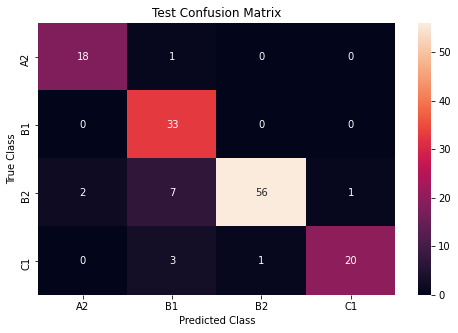

In [125]:
class_names = ['A2', 'B1', 'B2', 'C1']
cm = confusion_matrix(y_test, y_pred_catboost, labels=class_names)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8, 5))
sns.heatmap(cm_df, annot=True)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

Матрица предсказаний на тестовой выборке показывает, что модель безошибочно определяет класс B1, почти без ошибок класс A2. В классе B2 большая часть ошибочных предсказаний выдаёт класс B1.

## Отчёт

Предоставлен датасет с выборкой фильмов и уровнем сложности языка для изучающих английский язык, файлы с субтитрами. Поставлена задача - разработать модель для предсказания уровня сложности фильма по файлу с субтитрами.

Датасет с выборкой фильмов предобработан - убраны дубликаты, количество уровней сложности языка сведено к 4-м: `A2`, `B1`, `B2`, `C1`

Из файлов с субтитрами получен текст диалогов, произведена его предобработка:
- текст очищен от тегов, дополнительных символов
- проведена токенизация, удалены стоп-слова
- использована лемматизация, слова приведены к начальной форме
- добавлены дополнительные признаки - общая продолжительность субтитров и средняя продолжительность одного субтитра
- каждый субтитр разбит на 3 части для увеличения количества наблюдений и повышения качества предсказания модели
- использованы различные способы векторизации - bag of words, TF-IDF и встроенный в модель Catboost.

Рассмотрены модели:
- LogisticRegressionCV с использованием векторизации bag of words и TF-IDF
- Catboost с использованием векторизации bag of words и TF-IDF, а также с использованием встроенного средства.

Проведено обучение моделей на обучающей выборке с использованием кросс-валидации, проведена проверка качества лучших моделей на тестовой выборке.

Результаты:
- На обучающей выборке были близки результаты LogisticRegressionCV с TF-IDF и Catboost с использованием встроенного средства векторизации.
- На тестовой выборке повторить высокие результаты метрики удалось лишь модели Catboost

In [130]:
print(f'Результаты Catboost на кросс-валидации: \n    balanced accuracy {acc_catboost:.2f} (+/- {acc_std_catboost:.2f})\n')
print('Результаты Catboost на тестовой выборке:')
print(f'    balanced accuracy: {balanced_accuracy_score(y_test, y_pred_catboost):.4f}')
print(f'    F1 score micro, catboost: {f1_score(y_test, y_pred_catboost, average="micro"):.4}') 

Результаты Catboost на кросс-валидации: 
    balanced accuracy 0.86 (+/- 0.03)

Результаты Catboost на тестовой выборке:
    balanced accuracy: 0.9073
    F1 score micro, catboost: 0.8944
